# Raster Analysis with Rioxarray

## Introduction

## Learning Objectives

## Setting Up Your Rioxarray Environment

### Installing Required Libraries

In [1]:
# %pip install rioxarray pygis

### Importing Libraries and Configuration

In [2]:
import rioxarray
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import dask

# Configure Xarray for better display
xr.set_options(keep_attrs=True, display_expand_data=False)

# Configure matplotlib for high-quality plots
plt.rcParams["figure.dpi"] = 150

## Loading and Exploring Georeferenced Raster Data

### Understanding Raster Data Structure

### Loading a Real Satellite Image

In [3]:
# Load a Landsat satellite image covering Las Vegas area
url = "https://github.com/opengeos/datasets/releases/download/raster/LC09_039035_20240708_90m.tif"
data = rioxarray.open_rasterio(url)
print(f"Successfully loaded raster with shape: {data.shape}")
data

Successfully loaded raster with shape: (7, 2563, 2485)


<xarray.DataArray (band: 7, y: 2563, x: 2485)> Size: 178MB
[44583385 values with dtype=float32]
Coordinates:
  * band         (band) int64 56B 1 2 3 4 5 6 7
  * x            (x) float64 20kB 5.824e+05 5.825e+05 ... 8.059e+05 8.06e+05
  * y            (y) float64 21kB 4.106e+06 4.105e+06 ... 3.875e+06 3.875e+06
    spatial_ref  int64 8B 0
Attributes: (12/96)
    ALGORITHM_SOURCE_SURFACE_REFLECTANCE:  LaSRC_1.6.0
    ALGORITHM_SOURCE_SURFACE_TEMPERATURE:  st_1.5.0
    CLOUD_COVER:                           0
    CLOUD_COVER_LAND:                      0
    COLLECTION_CATEGORY:                   T1
    COLLECTION_NUMBER:                     2
    ...                                    ...
    WRS_TYPE:                              2
    AREA_OR_POINT:                         Area
    _FillValue:                            -inf
    scale_factor:                          1.0
    add_offset:                            0.0
    long_name:                             ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4...

### Exploring the Dataset Structure

In [4]:
# Examine the basic structure
print("Dataset dimensions:", data.dims)
print("Dataset shape:", data.shape)
print("Data type:", data.dtype)

Dataset dimensions: ('band', 'y', 'x')
Dataset shape: (7, 2563, 2485)
Data type: float32


In [5]:
# Explore the coordinate information
print("Coordinates:")
for name, coord in data.coords.items():
    print(f"  {name}: {coord.values.min()} to {coord.values.max()}")

Coordinates:
  band: 1 to 7
  x: 582435.0 to 805995.0
  y: 3874995.0 to 4105575.0
  spatial_ref: 0 to 0


In [6]:
# Check metadata attributes
print("\nKey attributes:")
for key, value in data.attrs.items():
    if key in ["long_name", "grid_mapping", "AREA_OR_POINT"]:
        print(f"  {key}: {value}")


Key attributes:
  AREA_OR_POINT: Area
  long_name: ('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7')


### Accessing Spatial Reference Information

In [7]:
# Check the coordinate reference system
print(f"Coordinate Reference System: {data.rio.crs}")

Coordinate Reference System: EPSG:32611


In [8]:
# Examine the affine transformation
print("\nAffine transformation:")
transform = data.rio.transform()
print(transform)
print(f"Pixel size: {abs(transform[0]):.1f} x {abs(transform[4]):.1f} meters")


Affine transformation:
| 90.00, 0.00, 582390.00|
| 0.00,-90.00, 4105620.00|
| 0.00, 0.00, 1.00|
Pixel size: 90.0 x 90.0 meters


### Setting CRS When Missing

In [9]:
# Example: Set CRS if missing or incorrect (only run if needed)
# data = data.rio.write_crs("EPSG:32611", inplace=True)
print(f"Current CRS is properly set: {data.rio.crs}")

Current CRS is properly set: EPSG:32611


## Fundamental Geospatial Operations

### Coordinate System Transformations

In [10]:
# Reproject from UTM to Geographic coordinates (WGS84)
print(f"Original CRS: {data.rio.crs}")
data_geographic = data.rio.reproject("EPSG:4326")
print(f"Reprojected CRS: {data_geographic.rio.crs}")
print(f"New coordinate ranges:")
print(
    f"  Longitude: {data_geographic.x.min().values:.3f} to {data_geographic.x.max().values:.3f}"
)
print(
    f"  Latitude: {data_geographic.y.min().values:.3f} to {data_geographic.y.max().values:.3f}"
)

Original CRS: EPSG:32611
Reprojected CRS: EPSG:4326
New coordinate ranges:
  Longitude: -116.097 to -113.559
  Latitude: 34.972 to 37.093


### Spatial Subsetting with Bounding Boxes

In [11]:
# Define a bounding box around central Las Vegas
# (longitude_min, latitude_min, longitude_max, latitude_max)
vegas_bbox = [-115.391, 35.982, -114.988, 36.425]

print("Clipping raster to Las Vegas area...")
clipped_data = data_geographic.rio.clip_box(*vegas_bbox)
print(f"Original size: {data_geographic.shape}")
print(f"Clipped size: {clipped_data.shape}")

Clipping raster to Las Vegas area...
Original size: (7, 2351, 2812)
Clipped size: (7, 492, 447)


### Vector-Based Clipping

In [12]:
import geopandas as gpd

# Load a vector boundary for more precise clipping
boundary_url = "https://github.com/opengeos/datasets/releases/download/places/las_vegas_bounds_utm.geojson"
boundary = gpd.read_file(boundary_url)

print(f"Boundary CRS: {boundary.crs}")
print(f"Raster CRS: {data.rio.crs}")

# Clip the raster using the vector boundary
clipped_by_vector = data.rio.clip(boundary.geometry, boundary.crs)
print(f"Vector-clipped size: {clipped_by_vector.shape}")

Boundary CRS: EPSG:32611
Raster CRS: EPSG:32611
Vector-clipped size: (7, 522, 514)


## Working with Spatial Dimensions and Resolution

### Understanding Spatial Resolution

In [13]:
# Calculate current spatial resolution
transform = data.rio.transform()
x_resolution = abs(transform[0])
y_resolution = abs(transform[4])

print(f"Current spatial resolution:")
print(f"  X (East-West): {x_resolution:.1f} meters")
print(f"  Y (North-South): {y_resolution:.1f} meters")

# Calculate total area covered
width_km = (data.x.max() - data.x.min()).values / 1000
height_km = (data.y.max() - data.y.min()).values / 1000
print(f"\nSpatial extent:")
print(f"  Width: {width_km:.1f} km")
print(f"  Height: {height_km:.1f} km")

Current spatial resolution:
  X (East-West): 90.0 meters
  Y (North-South): 90.0 meters

Spatial extent:
  Width: 223.6 km
  Height: 230.6 km


### Resampling to Different Resolutions

In [14]:
# Resample to 1km resolution for regional analysis
print("Resampling to 1km resolution...")
resampled_data = data.rio.reproject(
    data.rio.crs, resolution=(1000, 1000)  # Keep the same CRS  # 1km x 1km pixels
)

print(f"Original shape: {data.shape}")
print(f"Resampled shape: {resampled_data.shape}")

# Calculate the reduction in data size
original_pixels = np.prod(data.shape)
resampled_pixels = np.prod(resampled_data.shape)
reduction_factor = original_pixels / resampled_pixels
print(f"Data reduction factor: {reduction_factor:.1f}x")

Resampling to 1km resolution...
Original shape: (7, 2563, 2485)
Resampled shape: (7, 231, 224)
Data reduction factor: 123.1x


### Spatial Subsetting by Coordinates

In [15]:
# Extract a subset using coordinate ranges (in geographic coordinates)
lon_range = (-115.391, -114.988)
lat_range = (35.982, 36.425)

print("Selecting subset by coordinate ranges...")
subset = data_geographic.sel(
    x=slice(*lon_range),
    y=slice(lat_range[1], lat_range[0]),  # Note: y coordinates often decrease
)

print(f"Subset shape: {subset.shape}")
print(f"Longitude range: {subset.x.min().values:.3f} to {subset.x.max().values:.3f}")
print(f"Latitude range: {subset.y.min().values:.3f} to {subset.y.max().values:.3f}")

Selecting subset by coordinate ranges...
Subset shape: (7, 491, 447)
Longitude range: -115.391 to -114.988
Latitude range: 35.983 to 36.425


## Visualizing Geospatial Raster Data

### Creating True-Color Composite Images

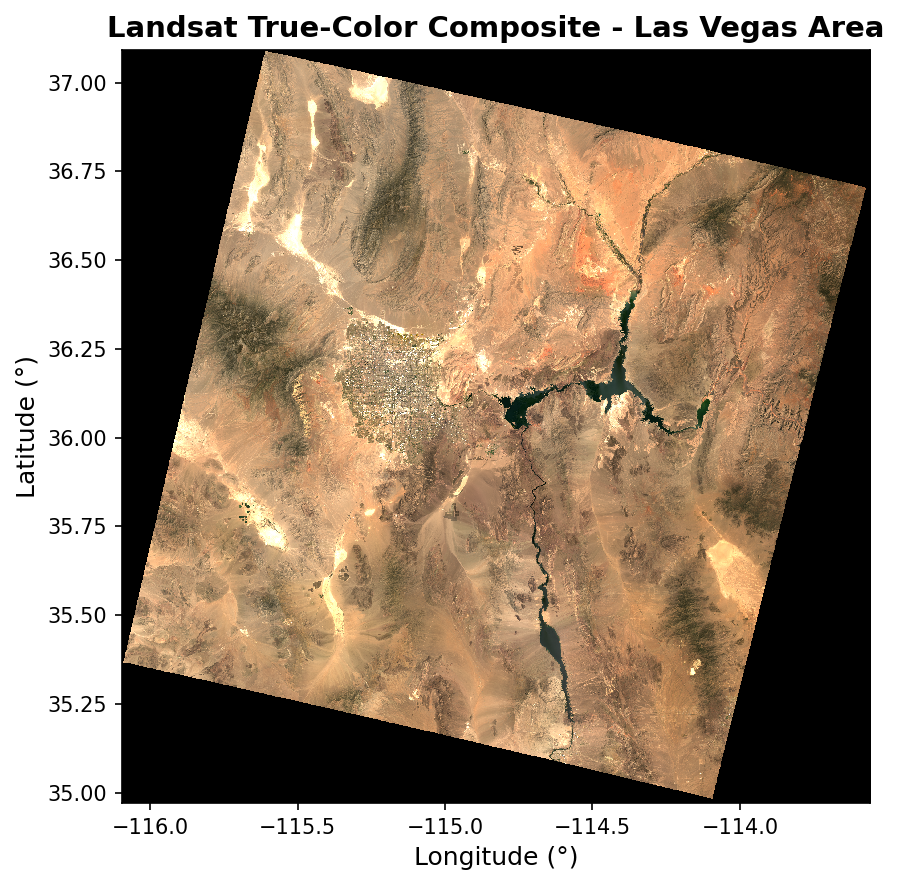

In [16]:
# Create a true-color (RGB) composite using bands 4, 3, 2 (Red, Green, Blue)
fig, ax = plt.subplots(figsize=(6, 6))

# Select RGB bands and create composite
rgb_bands = data_geographic.sel(band=[4, 3, 2])
rgb_bands.plot.imshow(
    ax=ax,
    vmin=0,
    vmax=0.3,  # Adjust based on data range
)
# ax.set_aspect('equal')
plt.title(
    "Landsat True-Color Composite - Las Vegas Area", fontsize=14, fontweight="bold"
)
plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("Latitude (°)", fontsize=12)
plt.tight_layout()
plt.show()

### Visualizing Individual Bands

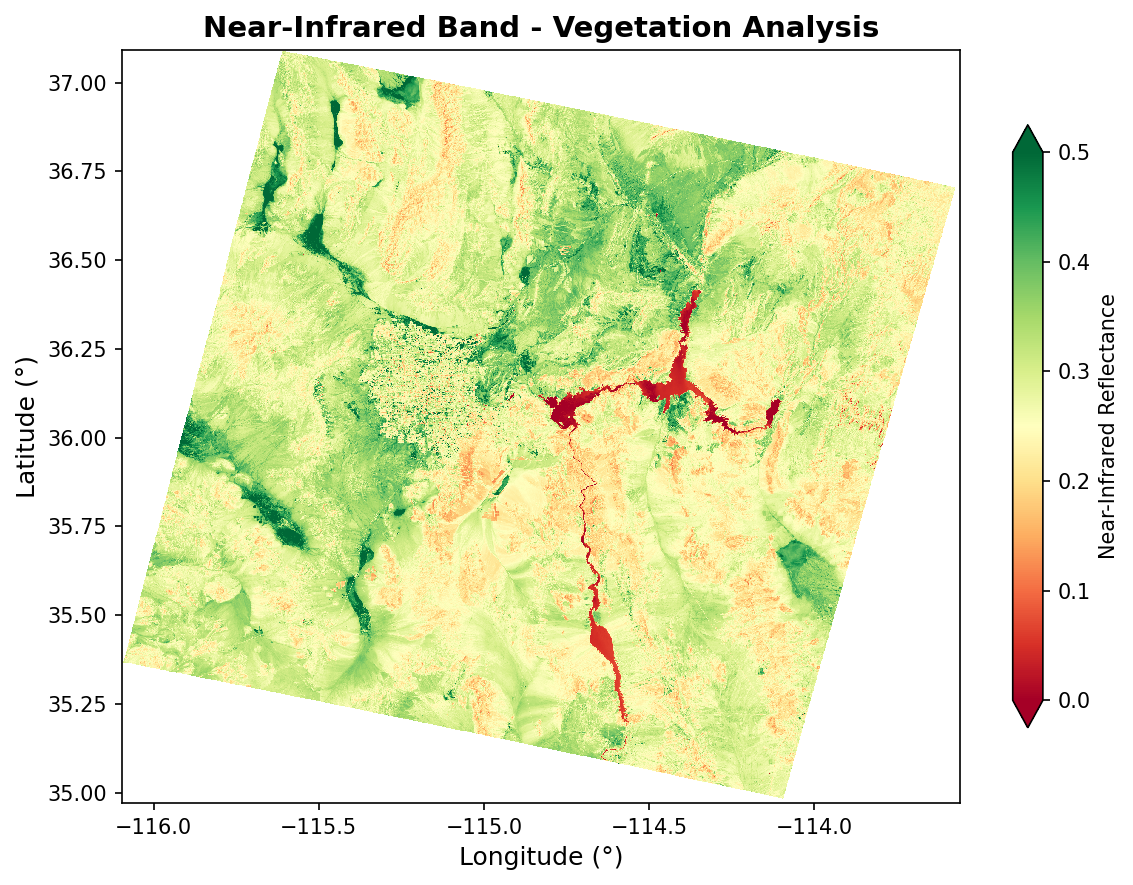

In [17]:
# Plot a single band with proper spatial context
fig, ax = plt.subplots(figsize=(8, 6))

# Select near-infrared band (band 5) which is useful for vegetation analysis
nir_band = data_geographic.sel(band=5)
im = nir_band.plot.imshow(
    ax=ax,
    cmap="RdYlGn",  # Red-Yellow-Green colormap
    vmin=0,
    vmax=0.5,
    add_colorbar=True,
    cbar_kwargs={"label": "Near-Infrared Reflectance", "shrink": 0.8},
)

plt.title("Near-Infrared Band - Vegetation Analysis", fontsize=14, fontweight="bold")
plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("Latitude (°)", fontsize=12)
plt.tight_layout()
plt.show()

### Overlaying Vector Data on Raster Images

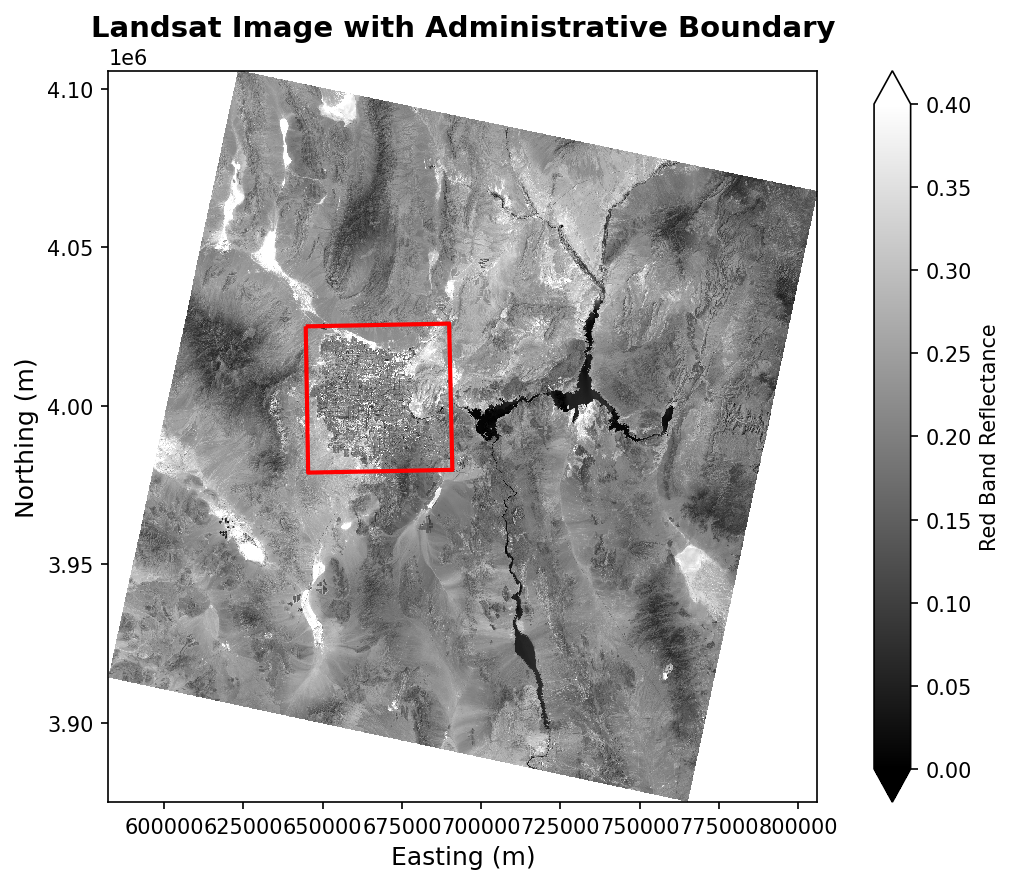

In [18]:
# Create a visualization with vector overlay
fig, ax = plt.subplots(figsize=(8, 6))

# Plot raster as background (single band for clarity)
data.attrs["long_name"] = "Surface Reflectance"
single_band = data.sel(band=4)  # Red band
single_band.plot.imshow(
    ax=ax,
    vmin=0,
    vmax=0.4,
    cmap="gray",
    add_colorbar=True,
    cbar_kwargs={"label": "Red Band Reflectance"},
)

# Overlay vector boundary
if "boundary" in locals():
    boundary.to_crs(data.rio.crs).boundary.plot(ax=ax, color="red", linewidth=2)

plt.title("Landsat Image with Administrative Boundary", fontsize=14, fontweight="bold")
plt.xlabel("Easting (m)", fontsize=12)
plt.ylabel("Northing (m)", fontsize=12)
plt.tight_layout()
plt.show()

## Data Storage and File Management

### Saving Processed Raster Data

In [19]:
# Save processed data as GeoTIFF (most common geospatial raster format)
output_filename = "las_vegas_landsat_processed.tif"

# Add metadata before saving
clipped_data.attrs["processing_date"] = str(np.datetime64("now"))
clipped_data.attrs["processed_by"] = "rioxarray tutorial"
clipped_data.attrs["description"] = "Landsat image clipped to Las Vegas area"

print(f"Saving processed data to {output_filename}...")
clipped_data.rio.to_raster(output_filename)
print("File saved successfully!")

# Verify the saved file
saved_data = rioxarray.open_rasterio(output_filename)
print(f"Verified: Saved file has shape {saved_data.shape} and CRS {saved_data.rio.crs}")

Saving processed data to las_vegas_landsat_processed.tif...
File saved successfully!
Verified: Saved file has shape (7, 492, 447) and CRS EPSG:4326


In [20]:
output_filename = "las_vegas_landsat_processed_cog.tif"
clipped_data.rio.to_raster(output_filename, driver="COG")

### Managing NoData Values

In [21]:
# Check for existing NoData values
print("Current NoData value:", data.rio.nodata)

# Set NoData value if needed
data_with_nodata = data.rio.set_nodata(-9999)
print("Updated NoData value:", data_with_nodata.rio.nodata)

Current NoData value: -inf
Updated NoData value: -9999


In [22]:
# Example: Mask out extreme values as NoData
# This is useful for removing outliers or invalid measurements
masked_data = data.where(data < 1.0, -9999)  # Mask very high reflectance values
masked_data = masked_data.rio.set_nodata(-9999)
print(f"Applied masking: {np.sum(masked_data == -9999).values} pixels set to NoData")

Applied masking: 14 pixels set to NoData


## Coordinate System Comparisons

In [23]:
# Compare the same data in different coordinate systems
print("Comparing coordinate systems...")

# Web Mercator (common for web mapping)
mercator_data = data.rio.reproject("EPSG:3857")
print(f"Web Mercator (EPSG:3857): {mercator_data.rio.crs}")
print(
    f"  Coordinate range: X: {mercator_data.x.min().values:.0f} to {mercator_data.x.max().values:.0f}"
)
print(
    f"                    Y: {mercator_data.y.min().values:.0f} to {mercator_data.y.max().values:.0f}"
)

# Geographic coordinates (WGS84)
print(f"\nGeographic (EPSG:4326): {data_geographic.rio.crs}")
print(
    f"  Coordinate range: Lon: {data_geographic.x.min().values:.3f} to {data_geographic.x.max().values:.3f}"
)
print(
    f"                    Lat: {data_geographic.y.min().values:.3f} to {data_geographic.y.max().values:.3f}"
)

Comparing coordinate systems...
Web Mercator (EPSG:3857): EPSG:3857
  Coordinate range: X: -12923800 to -12641328
                    Y: 4160003 to 4452058

Geographic (EPSG:4326): EPSG:4326
  Coordinate range: Lon: -116.097 to -113.559
                    Lat: 34.972 to 37.093


### Side-by-Side Coordinate System Visualization

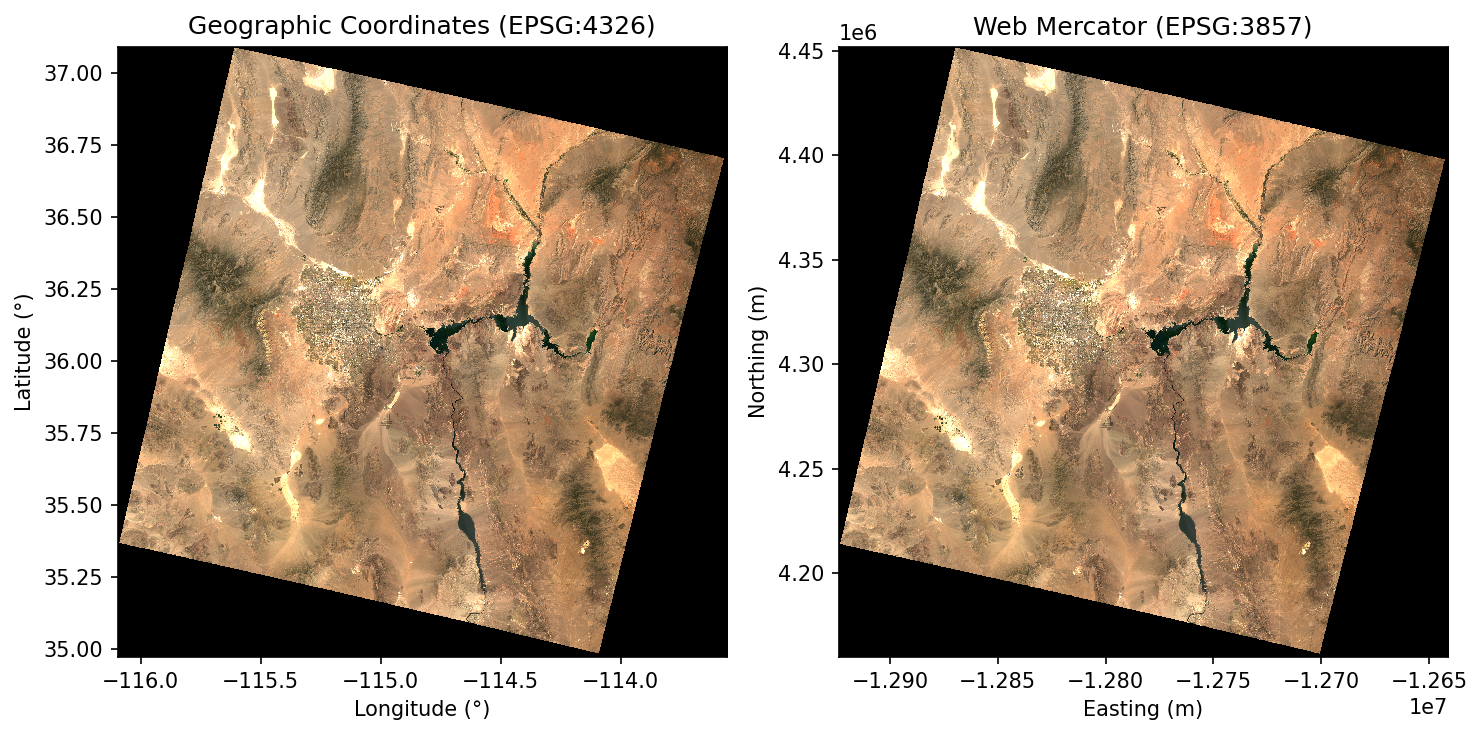

In [24]:
# Create side-by-side comparison of different projections
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot in geographic coordinates
data_geographic.sel(band=[4, 3, 2]).plot.imshow(ax=ax1, vmin=0, vmax=0.3)
ax1.set_title("Geographic Coordinates (EPSG:4326)")
ax1.set_xlabel("Longitude (°)")
ax1.set_ylabel("Latitude (°)")

# Plot in Web Mercator
mercator_data.sel(band=[4, 3, 2]).plot.imshow(ax=ax2, vmin=0, vmax=0.3)
ax2.set_title("Web Mercator (EPSG:3857)")
ax2.set_xlabel("Easting (m)")
ax2.set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()

## Introduction to Band Math

### Computing Vegetation Indices

In [25]:
# Calculate NDVI using the standard formula: (NIR - Red) / (NIR + Red)
print("Calculating NDVI...")

# Extract the required bands
red_band = data_geographic.sel(band=4)  # Red band
nir_band = data_geographic.sel(band=5)  # Near-infrared band

# Calculate NDVI with proper handling of division by zero
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Clip values to valid NDVI range and handle any invalid calculations
ndvi = ndvi.clip(min=-1, max=1)
ndvi = ndvi.where(np.isfinite(ndvi))  # Remove infinite values

# Add descriptive metadata
ndvi.attrs["long_name"] = "Normalized Difference Vegetation Index"
ndvi.attrs["valid_range"] = "[-1, 1]"
ndvi.attrs["description"] = "NDVI = (NIR - Red) / (NIR + Red)"

print(f"NDVI statistics:")
print(f"  Range: {ndvi.min().values:.3f} to {ndvi.max().values:.3f}")
print(f"  Mean: {ndvi.mean().values:.3f}")

Calculating NDVI...
NDVI statistics:
  Range: -1.000 to 1.000
  Mean: 0.139


### Visualizing Vegetation Analysis

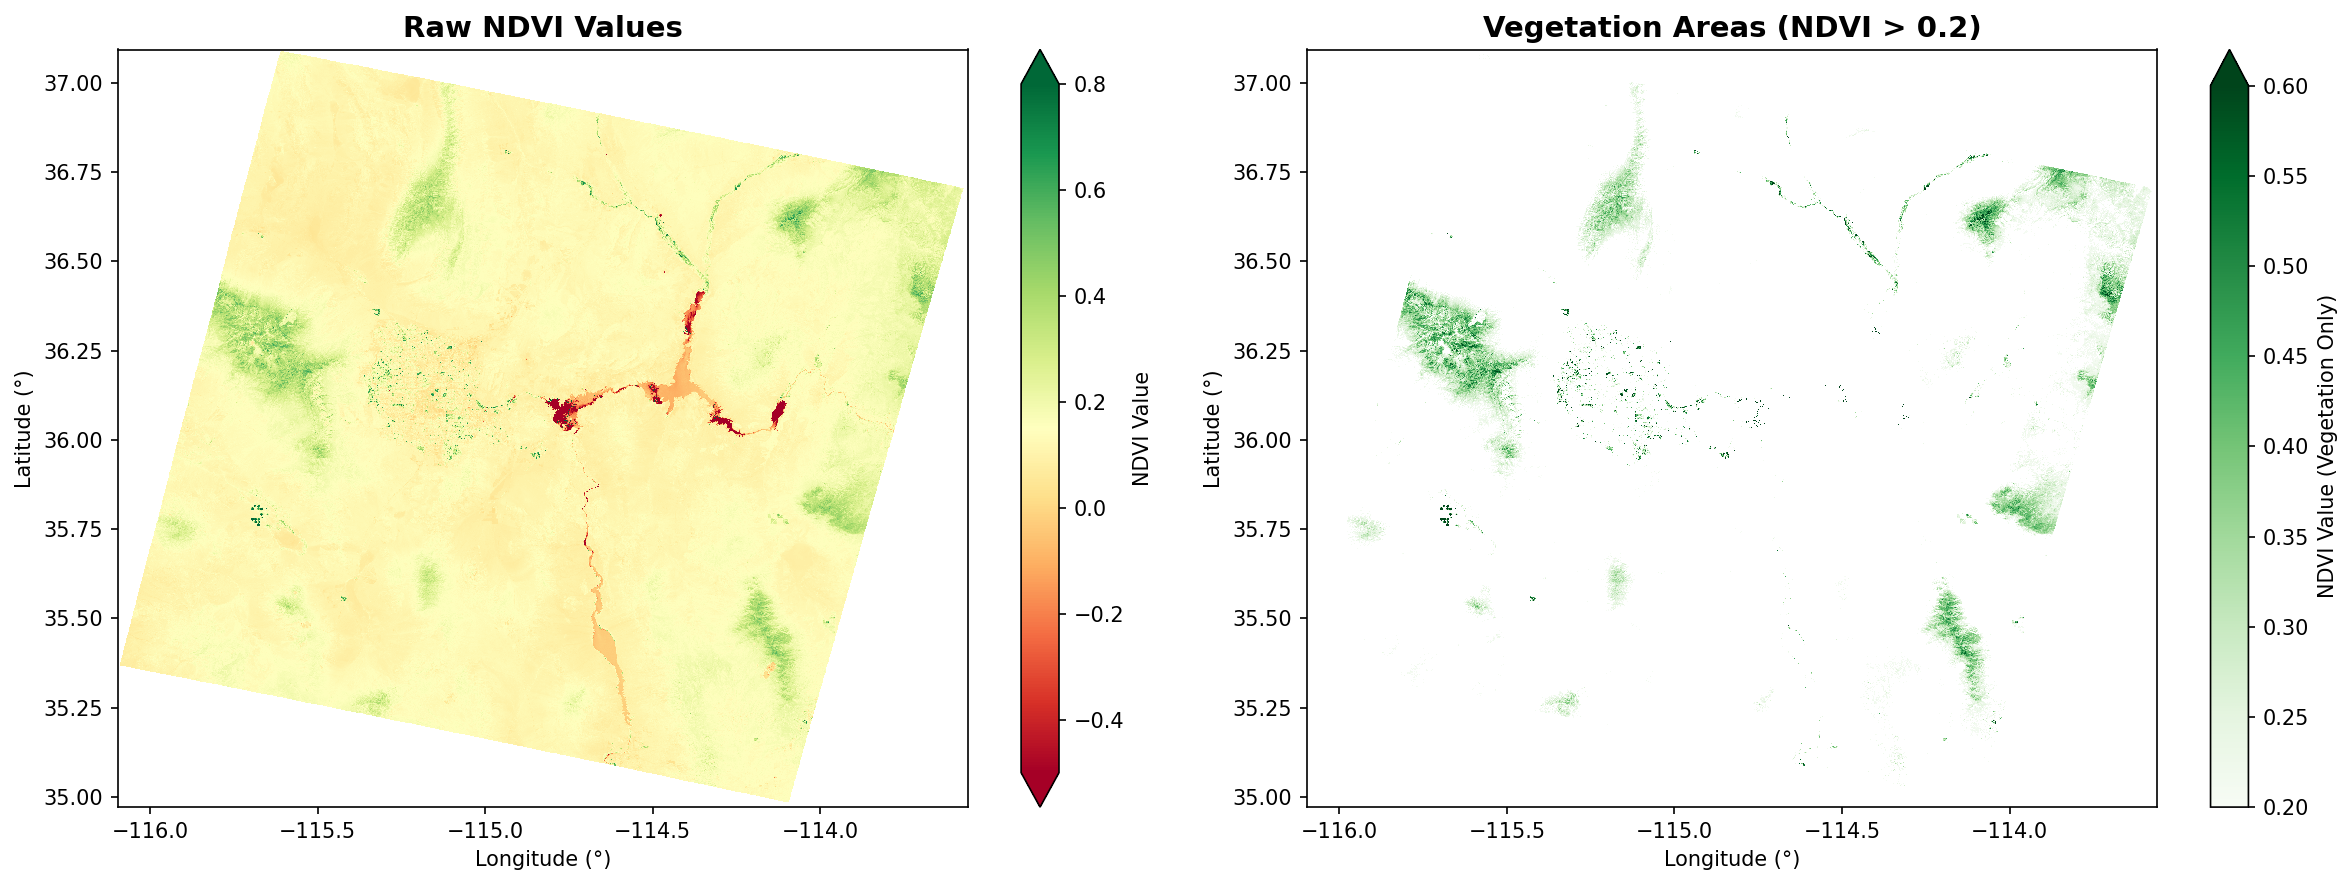

In [26]:
# Create a comprehensive NDVI visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot raw NDVI
ndvi.plot.imshow(
    ax=ax1,
    cmap="RdYlGn",
    vmin=-0.5,
    vmax=0.8,
    add_colorbar=True,
    cbar_kwargs={"label": "NDVI Value"},
)
ax1.set_title("Raw NDVI Values", fontsize=14, fontweight="bold")
ax1.set_xlabel("Longitude (°)")
ax1.set_ylabel("Latitude (°)")

# Plot vegetation areas only (NDVI > 0.2)
vegetation_mask = ndvi.where(ndvi > 0.2)
vegetation_mask.plot.imshow(
    ax=ax2,
    cmap="Greens",
    vmin=0.2,
    vmax=0.6,
    add_colorbar=True,
    cbar_kwargs={"label": "NDVI Value (Vegetation Only)"},
)
ax2.set_title("Vegetation Areas (NDVI > 0.2)", fontsize=14, fontweight="bold")
ax2.set_xlabel("Longitude (°)")
ax2.set_ylabel("Latitude (°)")

plt.tight_layout()
plt.show()

### Interpreting NDVI Results

In [27]:
# Analyze vegetation distribution
total_pixels = ndvi.size
vegetation_pixels = np.sum(ndvi > 0.2).values
water_pixels = np.sum(ndvi < 0).values
urban_pixels = np.sum((ndvi >= 0) & (ndvi <= 0.2)).values

print("NDVI Analysis Results:")
print(f"  Total pixels analyzed: {total_pixels:,}")
print(
    f"  Vegetation pixels (NDVI > 0.2): {vegetation_pixels:,} ({100*vegetation_pixels/total_pixels:.1f}%)"
)
print(
    f"  Water pixels (NDVI < 0): {water_pixels:,} ({100*water_pixels/total_pixels:.1f}%)"
)
print(
    f"  Urban/Bare soil (0 ≤ NDVI ≤ 0.2): {urban_pixels:,} ({100*urban_pixels/total_pixels:.1f}%)"
)

NDVI Analysis Results:
  Total pixels analyzed: 6,611,012
  Vegetation pixels (NDVI > 0.2): 443,905 (6.7%)
  Water pixels (NDVI < 0): 49,862 (0.8%)
  Urban/Bare soil (0 ≤ NDVI ≤ 0.2): 4,000,320 (60.5%)


## Key Takeaways

## Exercises

### Sample Dataset

### Exercise 1: Load and Inspect a Raster Dataset

In [28]:
url = 'https://github.com/opengeos/datasets/releases/download/raster/Libya-2023-09-13.tif'
data = rioxarray.open_rasterio(url)
data
# Print dimensions, shape and data type
print("Dataset dimensions:", data.dims)
print("Dataset shape:", data.shape)
print("Data type:", data.dtype)
print()

# Print coordinates
print("Coordinates:")
for name, coord in data.coords.items():
    print(f"  {name}: {coord.values.min()} to {coord.values.max()}")
print()

# Print attributes
print("\nKey attributes:")
for key, value in data.attrs.items():
    if key in ["long_name", "grid_mapping", "AREA_OR_POINT"]:
        print(f"  {key}: {value}")
print()

# Print Coordinate Reerence Sustem and affine transform
print(f"Coordinate Reference System: {data.rio.crs}")
print()
print("\nAffine transformation:")
transform = data.rio.transform()
print(transform)
print(f"Pixel size: {abs(transform[0]):.1f} x {abs(transform[4]):.1f} meters")
print()

# Print x and y resolution and the extent of data
sres, yres = data.rio.resolution()
print(f'Spatial Resolution is x:{sres}, y:{yres}')
minx, miny, maxx, maxy = data.rio.bounds()
print(f"Extent: minx={minx}, miny={miny}, maxx={maxx}, maxy={maxy}")







Dataset dimensions: ('band', 'y', 'x')
Dataset shape: (3, 17408, 17408)
Data type: uint8

Coordinates:
  band: 1 to 3
  x: 649843.9025878906 to 655156.0974121094
  y: 3624843.9025878906 to 3630156.0974121094
  spatial_ref: 0 to 0


Key attributes:
  AREA_OR_POINT: Area

Coordinate Reference System: EPSG:32634


Affine transformation:
| 0.31, 0.00, 649843.75|
| 0.00,-0.31, 3630156.25|
| 0.00, 0.00, 1.00|
Pixel size: 0.3 x 0.3 meters

Spatial Resolution is x:0.30517578125, y:-0.30517578125
Extent: minx=649843.75, miny=3624843.75, maxx=655156.25, maxy=3630156.25


### Exercise 2: Coordinate System Transformation

In [29]:

# Reproject from UTM to Geographic coordinates (WGS84)
print(f"Original CRS: {data.rio.crs}")


data = rioxarray.open_rasterio(url, chunks={"x": 1024, "y": 1024})  # Chunk size example
data_geographic = data.rio.reproject("EPSG:4326")
data_geographic = data_geographic.persist() 

print(f"Reprojected CRS: {data_geographic.rio.crs}")
print(f"New coordinate ranges:")
print(
    f"  Longitude: {data_geographic.x.min().values:.3f} to {data_geographic.x.max().values:.3f}"
)
print(
    f"  Latitude: {data_geographic.y.min().values:.3f} to {data_geographic.y.max().values:.3f}"
)


Original CRS: EPSG:32634
Reprojected CRS: EPSG:4326
New coordinate ranges:
  Longitude: 22.599 to 22.657
  Latitude: 32.751 to 32.799


In [30]:
# Calculate current spatial resolution
transform = data.rio.transform()
x_resolution = abs(transform[0])
y_resolution = abs(transform[4])

print(f"Current spatial resolution:")
print(f"  X (East-West): {x_resolution:.1f} meters")
print(f"  Y (North-South): {y_resolution:.1f} meters")

# Calculate total area covered
width_km = (data.x.max() - data.x.min()).values / 1000
height_km = (data.y.max() - data.y.min()).values / 1000
print(f"\nSpatial extent:")
print(f"  Width: {width_km:.1f} km")
print(f"  Height: {height_km:.1f} km")

Current spatial resolution:
  X (East-West): 0.3 meters
  Y (North-South): 0.3 meters

Spatial extent:
  Width: 5.3 km
  Height: 5.3 km


In [31]:
# # Plot single band -- Kills my kernel
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Original
# data[0, :, :].plot(ax=axes[0], cmap='viridis')
# axes[0].set_title('Original (UTM)')

# # Reprojected
# data_geographic[0, :, :].plot(ax=axes[1], cmap='viridis')
# axes[1].set_title('Reprojected (Geographic)')

# plt.tight_layout()
# plt.show()

### Exercise 3: Spatial Subsetting with Bounding Boxes

Clipping raster to random area...
Original size: (3, 16172, 19142)
Clipped size: (3, 1822, 18973)
<xarray.DataArray 'band' (band: 3)> Size: 24B
1 2 3
Coordinates:
  * band         (band) int64 24B 1 2 3
    spatial_ref  int64 8B 0


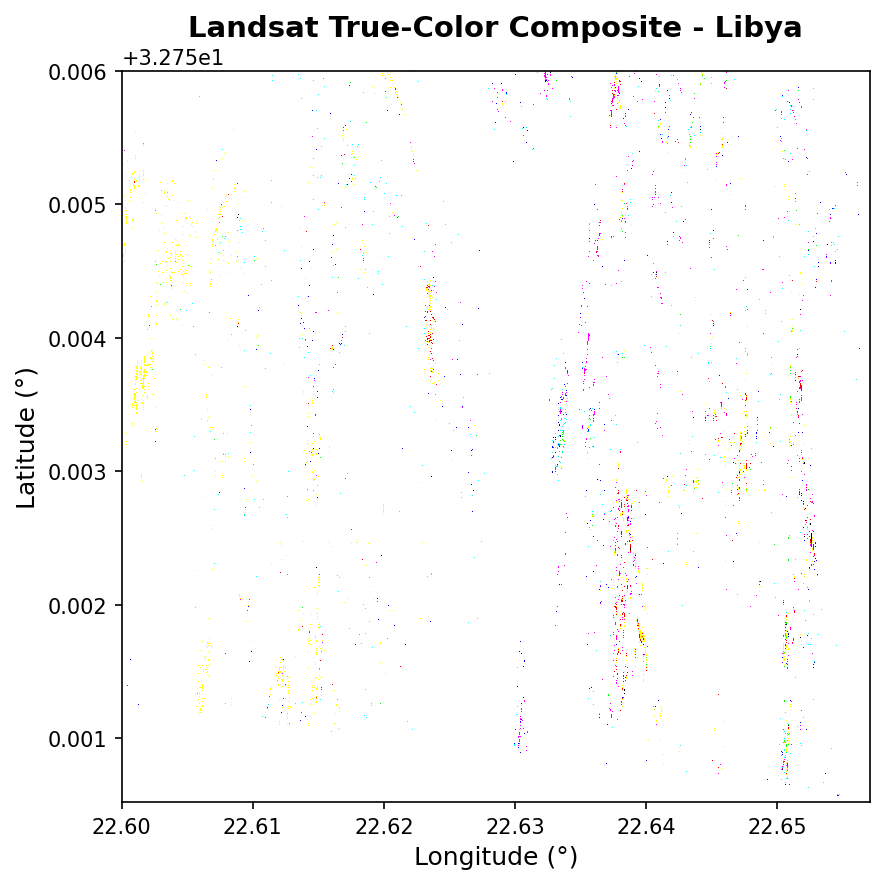

: 

In [ ]:
random_bbox = [22.600, 22.605, 32.752, 32.756]

print("Clipping raster to random area...")
clipped_data = data_geographic.rio.clip_box(*random_bbox)
print(f"Original size: {data_geographic.shape}")
print(f"Clipped size: {clipped_data.shape}")

print(clipped_data.coords['band'])

# Create a true-color (RGB) composite using bands 3,2,1 (Red, Green, Blue)
fig, ax = plt.subplots(figsize=(6, 6))

# Select RGB bands and create composite
rgb_bands = clipped_data.sel(band=[3, 2, 1])
rgb_bands.plot.imshow(
    ax=ax,
    vmin=0,
    vmax=0.3,  # Adjust based on data range
)
# ax.set_aspect('equal')
plt.title(
    "Landsat True-Color Composite - Libya", fontsize=14, fontweight="bold"
)
plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("Latitude (°)", fontsize=12)
plt.tight_layout()
plt.show()


### Exercise 4: Vector-Based Masking

In [ ]:
import geopandas as gpd

boundary_url = 'https://github.com/opengeos/datasets/releases/download/raster/Derna_Libya.geojson'

boundary = gpd.read_file(boundary_url)

print(f"Boundary CRS: {boundary.crs}")
print(f"Raster CRS: {data_geographic.rio.crs}")

# Clip the raster using the vector boundary
clipped_by_vector = data_geographic.rio.clip(boundary.geometry, boundary.crs)
print(f"Vector-clipped size: {clipped_by_vector.shape}")

# My kernel keeps on killing... I will not display the data in hopes to not kill the kernel

Boundary CRS: EPSG:4326
Raster CRS: EPSG:4326


### Exercise 5: Resolution Analysis and Data Export